In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sagemaker
from sagemaker.xgboost.estimator import XGBoost
import boto3
import json
import io
import os
from datetime import datetime

# Set up SageMaker session
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'walmart-sales-forecasting'
role = sagemaker.get_execution_role()

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')  # Updated style name for newer matplotlib versions
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [9]:
# Load data
df = pd.read_csv('Walmart_Store_sales.csv')

# Check basic information
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Convert date column to datetime - specify dayfirst=True for DD-MM-YYYY format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Extract date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Check if there are any holiday-related columns
if 'Holiday_Flag' in df.columns:
    print("\nDistribution of Holiday_Flag:")
    print(df['Holiday_Flag'].value_counts())
else:
    # Create a placeholder for holiday if not present
    df['Holiday_Flag'] = 0

# Check unique stores and departments
print("\nNumber of unique stores:", df['Store'].nunique())
if 'Dept' in df.columns:
    print("Number of unique departments:", df['Dept'].nunique())

Dataset shape: (6435, 8)

First 5 rows:


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



Distribution of Holiday_Flag:
Holiday_Flag
0    5985
1     450
Name: count, dtype: int64

Number of unique stores: 45


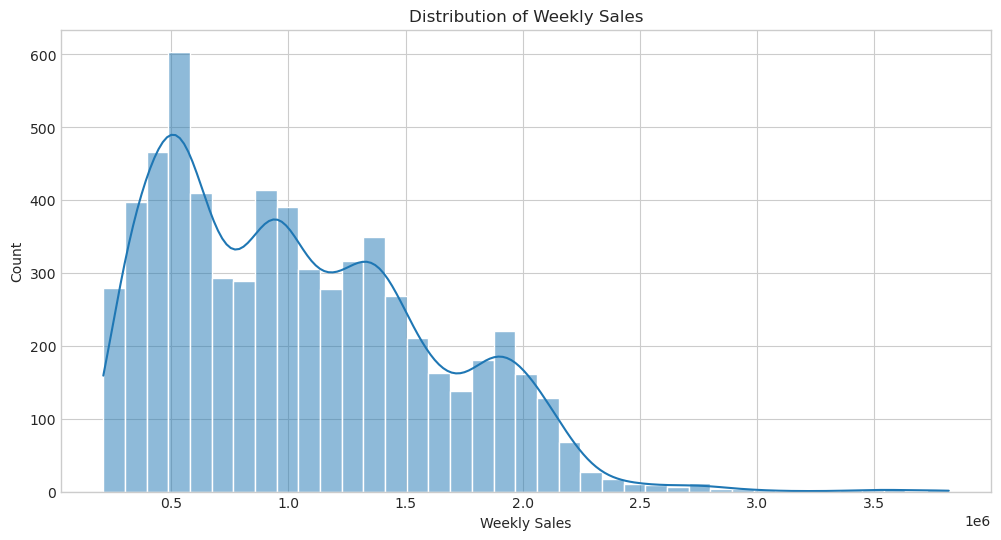

[04/21/25 19:14:42] INFO     Using categorical units to plot a list of strings that are all         ]8;id=624019;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=59923;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=301884;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=292549;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

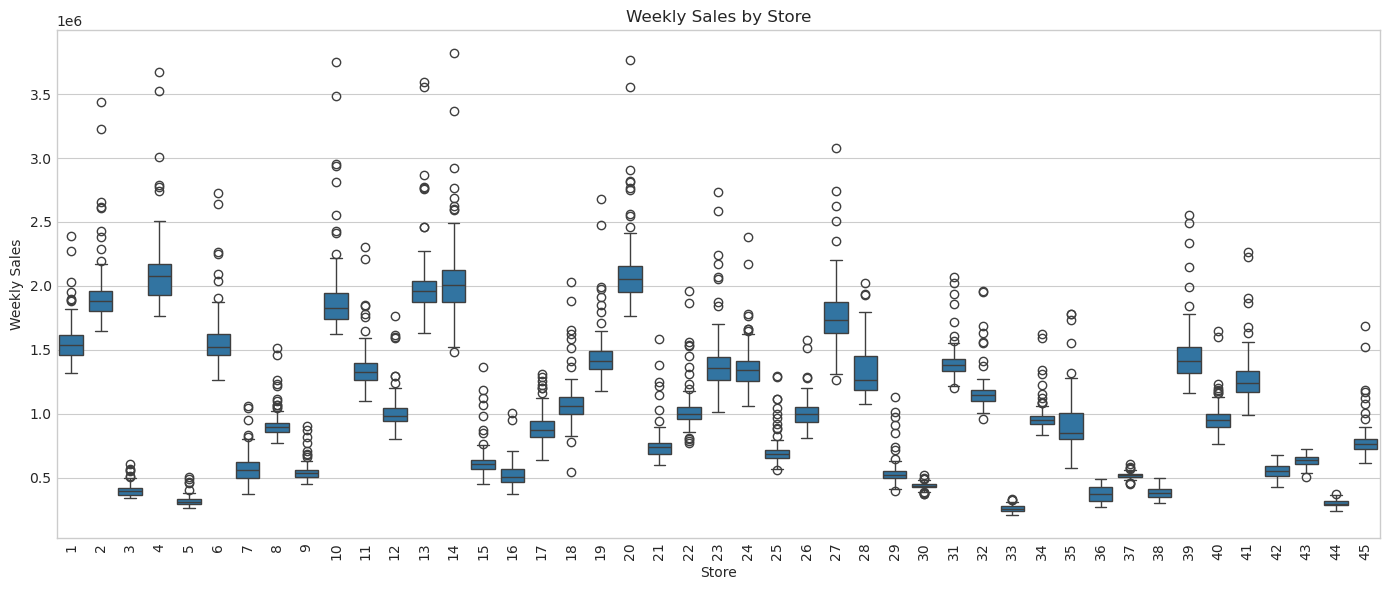

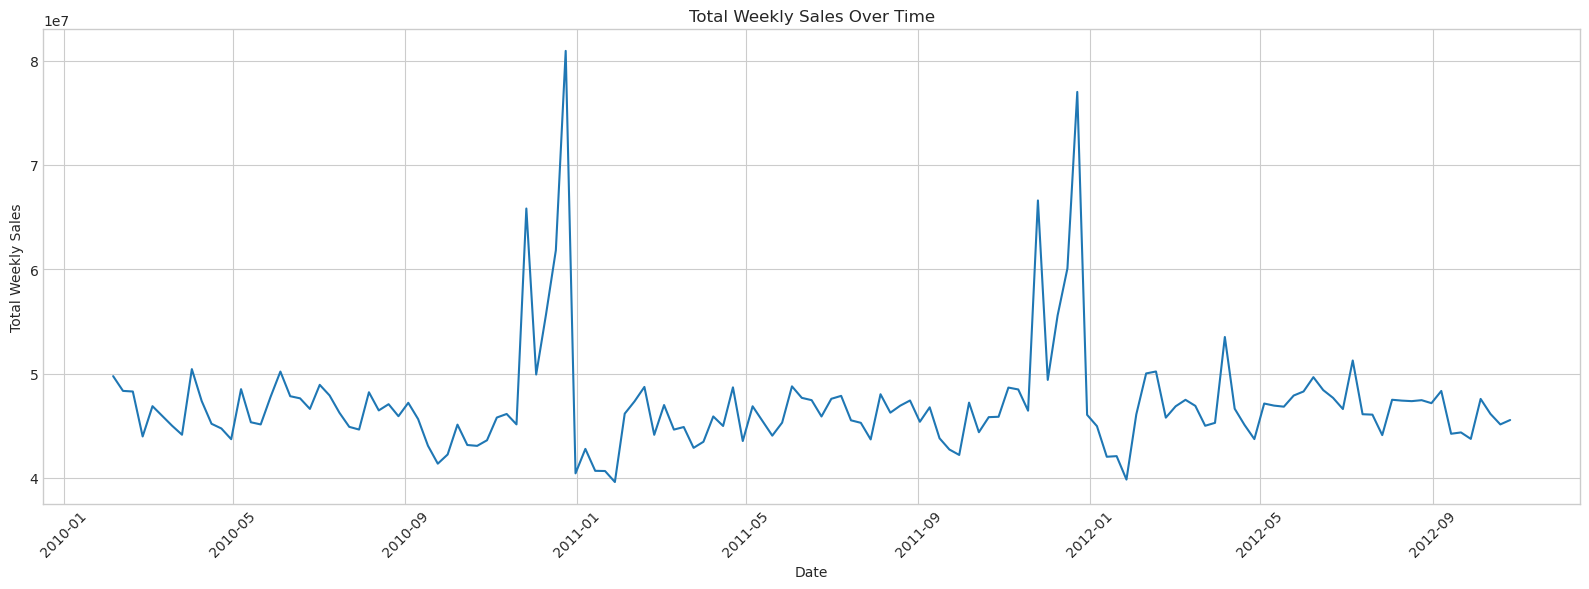

[04/21/25 19:14:43] INFO     Using categorical units to plot a list of strings that are all         ]8;id=141096;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=34019;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=478193;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=244386;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

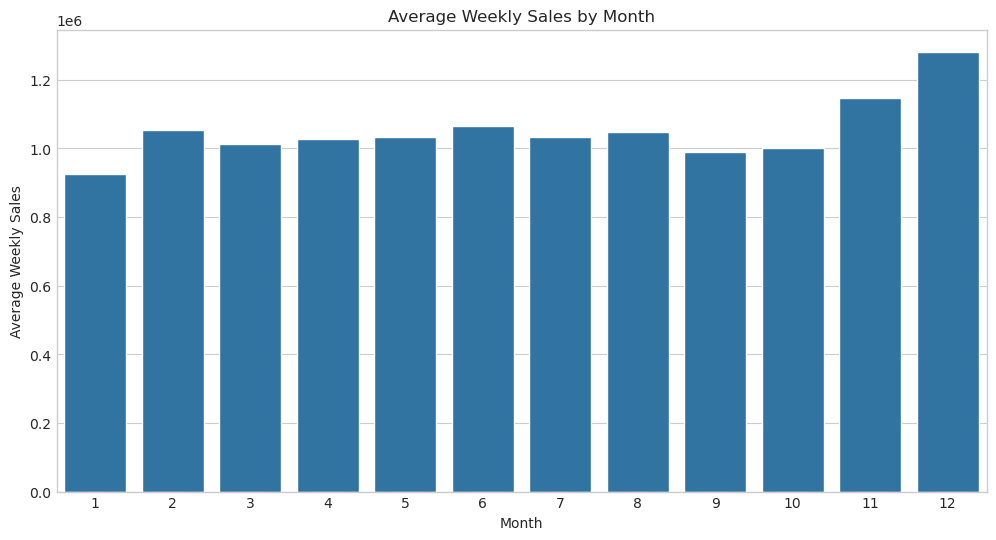

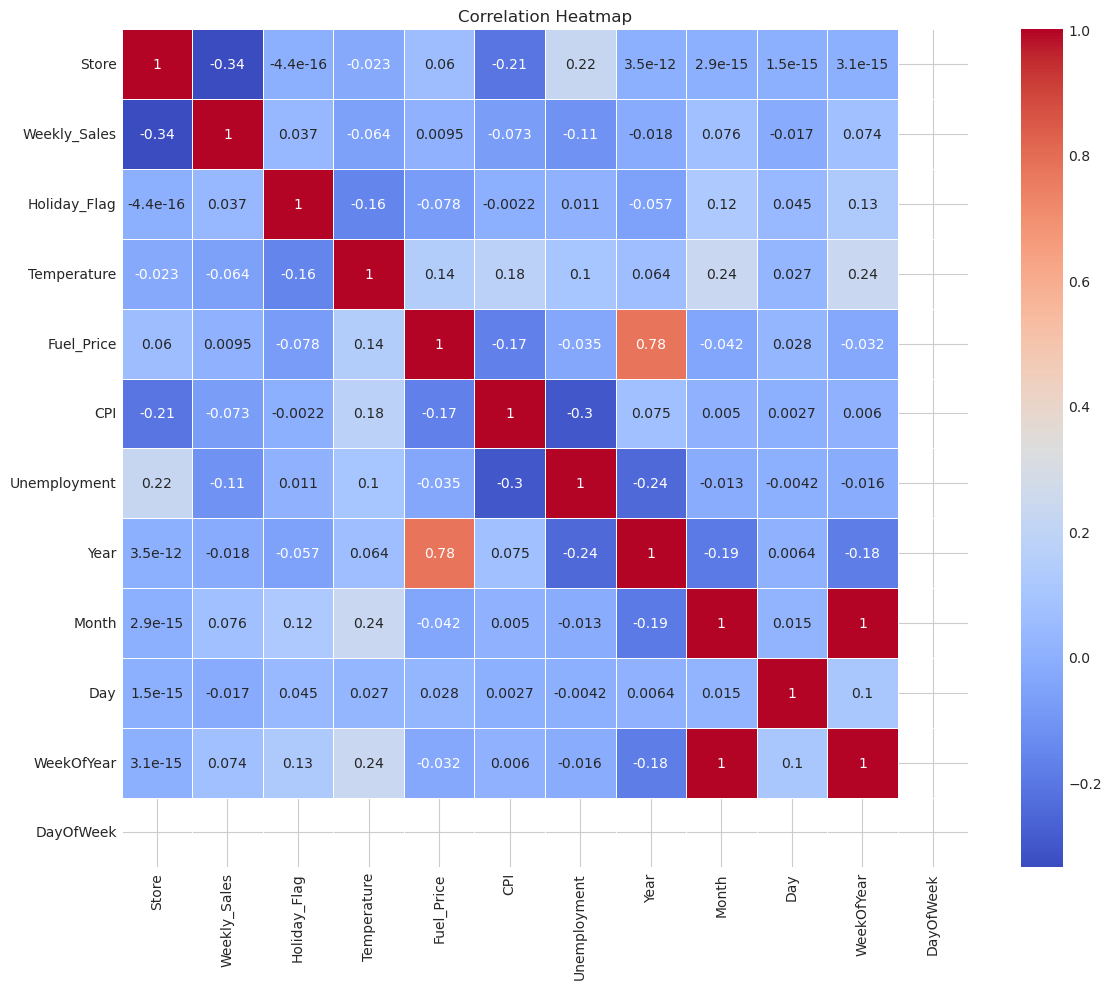

In [10]:
# Sales distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Weekly_Sales'], kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.show()

# Sales by store - convert Store to integer to avoid categorical warning
plt.figure(figsize=(14, 6))
# Convert Store to numeric type
df['Store'] = df['Store'].astype(int)
sns.boxplot(x='Store', y='Weekly_Sales', data=df)
plt.title('Weekly Sales by Store')
plt.xticks(rotation=90)
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()

# Time series of sales
if len(df['Date'].unique()) > 1:  # Only if we have multiple dates
    plt.figure(figsize=(16, 6))
    
    # Group by date and sum sales
    sales_by_date = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
    
    plt.plot(sales_by_date['Date'], sales_by_date['Weekly_Sales'])
    plt.title('Total Weekly Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Weekly Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Sales by month - convert Month to integer to avoid categorical warning
monthly_sales = df.groupby('Month')['Weekly_Sales'].mean().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(int)
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Weekly_Sales', data=monthly_sales)
plt.title('Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.show()

# Correlation heatmap
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12, 10))
correlation = df[numeric_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [11]:
# Create lag features (if we have time series data)
if len(df['Date'].unique()) > 1:
    # Sort data by store and date
    df = df.sort_values(['Store', 'Date'])
    
    # Create lag features for weekly sales (1, 2, 3 weeks ago)
    for lag in [1, 2, 3]:
        df[f'Sales_Lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)
    
    # Create rolling mean features
    df['Sales_Roll_Mean_4'] = df.groupby('Store')['Weekly_Sales'].rolling(window=4).mean().reset_index(level=0, drop=True)

# Drop rows with NaN values created by lags
df = df.dropna()

# Select features
if 'Sales_Lag_1' in df.columns:
    features = ['Store', 'Month', 'Day', 'Year', 'WeekOfYear', 'DayOfWeek', 
                'Holiday_Flag', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Roll_Mean_4']
else:
    features = ['Store', 'Month', 'Day', 'Year', 'WeekOfYear', 'DayOfWeek', 'Holiday_Flag']

# Add temperature and fuel price if available
if 'Temperature' in df.columns:
    features.append('Temperature')
if 'Fuel_Price' in df.columns:
    features.append('Fuel_Price')
if 'CPI' in df.columns:
    features.append('CPI')
if 'Unemployment' in df.columns:
    features.append('Unemployment')

print("Selected features:", features)

# Prepare X and y
X = df[features]
y = df['Weekly_Sales']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Selected features: ['Store', 'Month', 'Day', 'Year', 'WeekOfYear', 'DayOfWeek', 'Holiday_Flag', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Roll_Mean_4', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
Training set shape: (5040, 15)
Testing set shape: (1260, 15)


Mean Squared Error: 2466787021.14
Root Mean Squared Error: 49666.76
Mean Absolute Error: 33750.63
R² Score: 0.9919


<Figure size 1200x600 with 0 Axes>

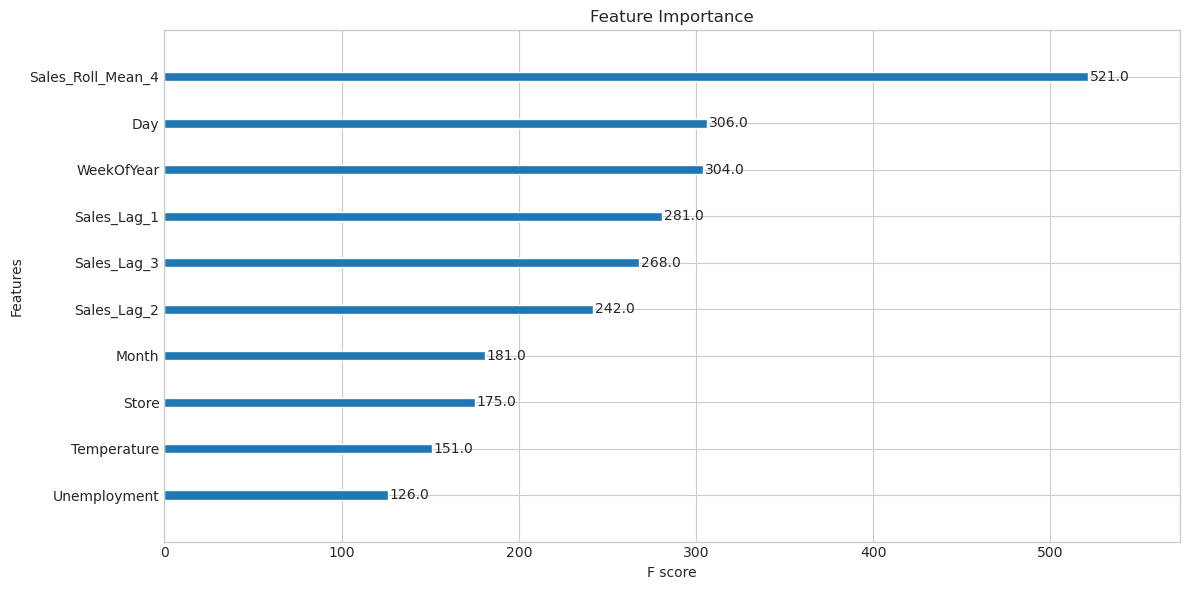

In [12]:
# Train XGBoost model locally first
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Training data uploaded to: s3://sagemaker-us-east-1-076481762662/walmart-sales-forecasting/train/train.csv
Testing data uploaded to: s3://sagemaker-us-east-1-076481762662/walmart-sales-forecasting/test/test.csv


[04/21/25 19:58:31] INFO     Ignoring unnecessary Python version: py3.                            ]8;id=599728;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=287289;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=488598;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=435688;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=556935;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=461975;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=446329;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=827423;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-21-19-58-31-877                                             

2025-04-21 19:58:33 Starting - Starting the training job...
2025-04-21 19:58:49 Starting - Preparing the instances for training...
2025-04-21 19:59:13 Downloading - Downloading input data...
2025-04-21 19:59:59 Downloading - Downloading the training image.....[2025-04-21 20:00:44.199 ip-10-0-235-88.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-21 20:00:44.229 ip-10-0-235-88.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-04-21:20:00:44:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-21:20:00:44:INFO] No GPUs detected (normal if no gpus installed)
[2025-04-21:20:00:44:INFO] Invoking user training script.
[2025-04-21:20:00:44:INFO] Module script does not provide a setup.py. 
Generating setup.py
[2025-04-21:20:00:44:INFO] Generating setup.cfg
[2025-04-21:20:00:44:INFO] Generating MANIFEST.in
[2025-04-21:20:00:44:INFO] Installing module with the following command:
/miniconda3/bin/python3 -m pip inst

[04/21/25 20:01:49] INFO     Creating model with name: sagemaker-xgboost-2025-04-21-20-01-49-499    ]8;id=519873;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=729378;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/21/25 20:01:50] INFO     Creating endpoint-config with name                                     ]8;id=541776;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=985070;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             sagemaker-xgboost-2025-04-21-20-01-49-499                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-04-21-20-01-49-499  ]8;id=198344;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=166851;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

--------!Sample test data:
         Store     Month       Day      Year  WeekOfYear  DayOfWeek  \
1935 -0.699933  0.138907  0.707419  0.013981    0.193679        0.0   
360  -1.551596  0.138907 -0.879366  0.013981    0.050266        0.0   
1531 -0.932205 -1.736332 -0.312657  1.272243   -1.742396        0.0   
4687  0.771120 -1.111253  0.820761  1.272243   -1.025331        0.0   
614  -1.396748  1.389066  1.160786 -1.244282    1.484395        0.0   

      Holiday_Flag  Sales_Lag_1  Sales_Lag_2  Sales_Lag_3  Sales_Roll_Mean_4  \
1935     -0.261246     1.603420     1.803943     1.816218           1.710625   
360      -0.261246    -1.198054    -1.172155    -1.137398          -1.189391   
1531     -0.261246     0.419491     0.542263     2.061611           0.870760   
4687     -0.261246    -1.358752    -1.346289    -1.411989          -1.411892   
614       3.827816    -1.324601    -1.320604    -1.275448          -1.252701   

      Temperature  Fuel_Price       CPI  Unemployment  
1935     

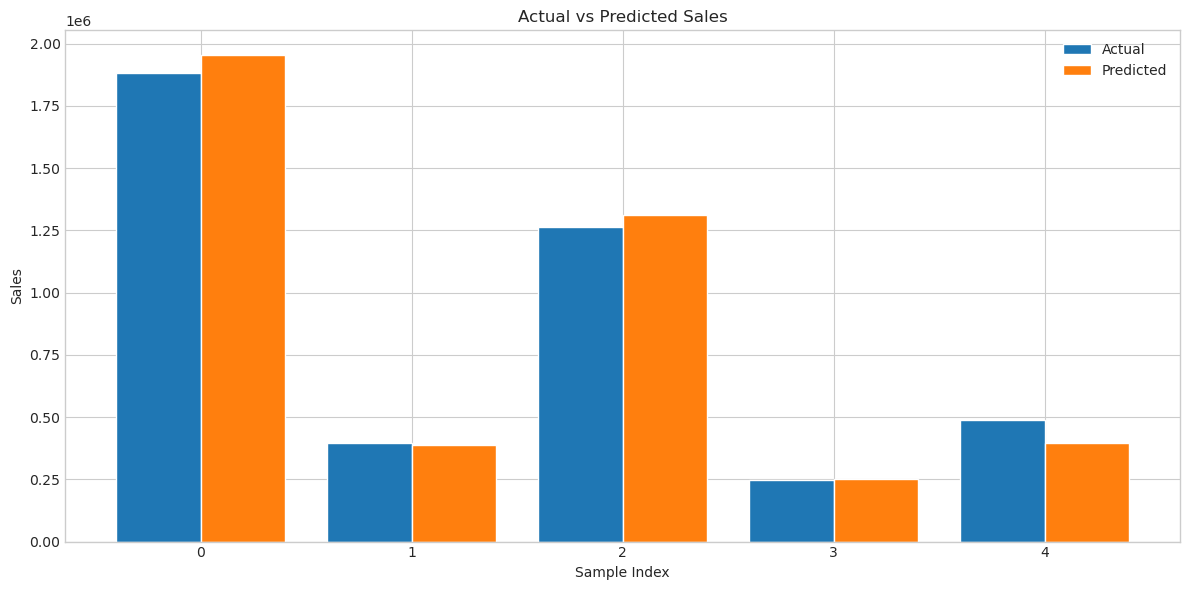

Cleaning up endpoint...


[04/21/25 20:06:23] INFO     Deleting endpoint configuration with name:                             ]8;id=96354;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=767919;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4913\4913]8;;\
                             sagemaker-xgboost-2025-04-21-20-01-49-499                                             

                    INFO     Deleting endpoint with name: sagemaker-xgboost-2025-04-21-20-01-49-499 ]8;id=919856;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=441671;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4903\4903]8;;\

Endpoint deleted.


In [14]:
import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.serializers import CSVSerializer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up SageMaker session
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'walmart-sales-forecasting'
role = sagemaker.get_execution_role()

# Prepare data for SageMaker
# SageMaker XGBoost expects data without headers and with the label column first
train_data = pd.concat([y_train, X_train], axis=1)
test_data = pd.concat([y_test, X_test], axis=1)

# Save data to CSV files
train_file = 'train.csv'
test_file = 'test.csv'
train_data.to_csv(train_file, header=False, index=False)
test_data.to_csv(test_file, header=False, index=False)

# Upload to S3
train_s3_path = session.upload_data(path=train_file, bucket=bucket, key_prefix=f"{prefix}/train")
test_s3_path = session.upload_data(path=test_file, bucket=bucket, key_prefix=f"{prefix}/test")
print(f"Training data uploaded to: {train_s3_path}")
print(f"Testing data uploaded to: {test_s3_path}")

# Create the training script file with improved serving functions
script_content = """
import os
import argparse
import pandas as pd
import numpy as np
import xgboost as xgb
import json
import io

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # Hyperparameters are passed as command-line arguments
    parser.add_argument('--max_depth', type=int, default=5)
    parser.add_argument('--eta', type=float, default=0.1)
    parser.add_argument('--gamma', type=float, default=0)
    parser.add_argument('--min_child_weight', type=int, default=1)
    parser.add_argument('--subsample', type=float, default=0.8)
    parser.add_argument('--objective', type=str, default='reg:squarederror')
    parser.add_argument('--num_round', type=int, default=100)
    
    # SageMaker specific arguments
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    
    args = parser.parse_args()
    
    # Load data
    train_df = pd.read_csv(os.path.join(args.train, 'train.csv'), header=None)
    validation_df = pd.read_csv(os.path.join(args.validation, 'test.csv'), header=None)
    
    # Split into features and target
    X_train = train_df.iloc[:, 1:].values
    y_train = train_df.iloc[:, 0].values
    X_validation = validation_df.iloc[:, 1:].values
    y_validation = validation_df.iloc[:, 0].values
    
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalidation = xgb.DMatrix(X_validation, label=y_validation)
    
    # Set XGBoost parameters
    params = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'gamma': args.gamma,
        'min_child_weight': args.min_child_weight,
        'subsample': args.subsample,
        'objective': args.objective
    }
    
    # Train the model
    watchlist = [(dtrain, 'train'), (dvalidation, 'validation')]
    model = xgb.train(params, dtrain, args.num_round, watchlist)
    
    # Save the model
    model_location = os.path.join(args.model_dir, 'xgboost-model')
    model.save_model(model_location)

# These functions are required for model serving
def model_fn(model_dir):
    \"\"\"Load the model for inference\"\"\"
    model_file = os.path.join(model_dir, 'xgboost-model')
    model = xgb.Booster()
    model.load_model(model_file)
    return model

def input_fn(request_body, request_content_type):
    \"\"\"Parse input data\"\"\"
    if request_content_type == 'text/csv':
        return np.loadtxt(io.StringIO(request_body), delimiter=',', dtype=float)
    else:
        raise ValueError(f'Unsupported content type: {request_content_type}')

def predict_fn(input_data, model):
    \"\"\"Make prediction with the model\"\"\"
    dmatrix = xgb.DMatrix(input_data)
    return model.predict(dmatrix)

def output_fn(prediction, accept):
    \"\"\"Format prediction output\"\"\"
    return ','.join(str(x) for x in prediction), 'text/csv'
"""

# Write the script content to a file
with open('script.py', 'w') as f:
    f.write(script_content)

# Create XGBoost estimator
xgb_estimator = XGBoost(
    entry_point='script.py',
    framework_version='1.3-1',
    hyperparameters={
        'max_depth': 5,
        'eta': 0.1,
        'gamma': 0,
        'min_child_weight': 1,
        'subsample': 0.8,
        'objective': 'reg:squarederror',
        'num_round': 100
    },
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output'
)

# Train the model
xgb_estimator.fit({'train': train_s3_path, 'validation': test_s3_path})

# Deploy the model with larger instance
predictor = xgb_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',  # Using a larger instance type
    serializer=sagemaker.serializers.CSVSerializer()  # Specify the serializer
)

# Test the deployed model
test_sample = test_data.iloc[:5, 1:].values.astype('float32')  # Exclude the label column
prediction = predictor.predict(test_sample)

print("Sample test data:")
print(test_data.iloc[:5, 1:])
print("\nPredictions from deployed model:")
print(prediction)

# Compare with actual values
actual = test_data.iloc[:5, 0].values
print("\nActual values:")
print(actual)

# Calculate error - fix for different prediction formats
if isinstance(prediction, list):
    # Handle nested list format
    prediction_array = np.array([float(x) for x in prediction[0]])
elif isinstance(prediction, str):
    # Handle string format
    prediction_array = np.array([float(x) for x in prediction.split(',')])
else:
    # Try to convert directly
    try:
        prediction_array = np.array(prediction, dtype=float)
    except:
        # If all else fails, try to extract first
        prediction_str = str(prediction)
        # Extract numbers from string using more robust method
        import re
        numbers = re.findall(r'[\d\.]+', prediction_str)
        prediction_array = np.array([float(x) for x in numbers])
    
error = np.mean(np.abs((actual - prediction_array) / actual)) * 100
print(f"\nMean Absolute Percentage Error: {error:.2f}%")

# Visualize predictions vs actual
plt.figure(figsize=(12, 6))
indices = range(len(actual))
plt.bar([i-0.2 for i in indices], actual, width=0.4, label='Actual', align='center')
plt.bar([i+0.2 for i in indices], prediction_array, width=0.4, label='Predicted', align='center')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Always clean up when done to avoid ongoing charges
print("Cleaning up endpoint...")
predictor.delete_endpoint()
print("Endpoint deleted.")

Sales Forecast for the Next 8 Weeks:


,Store,Date,Predicted_Sales
0,-1.706444,2012-11-04,1.598827e+06
1,-1.706444,2012-11-11,1.610086e+06
2,-1.706444,2012-11-18,1.580014e+06
3,-1.706444,2012-11-25,1.789758e+06
4,-1.706444,2012-12-02,1.744432e+06
5,-1.706444,2012-12-09,1.682704e+06
6,-1.706444,2012-12-16,1.689192e+06
7,-1.706444,2012-12-23,1.818046e+06
8,-1.629020,2012-12-30,1.910906e+06
9,-1.629020,2013-01-06,1.936490e+06


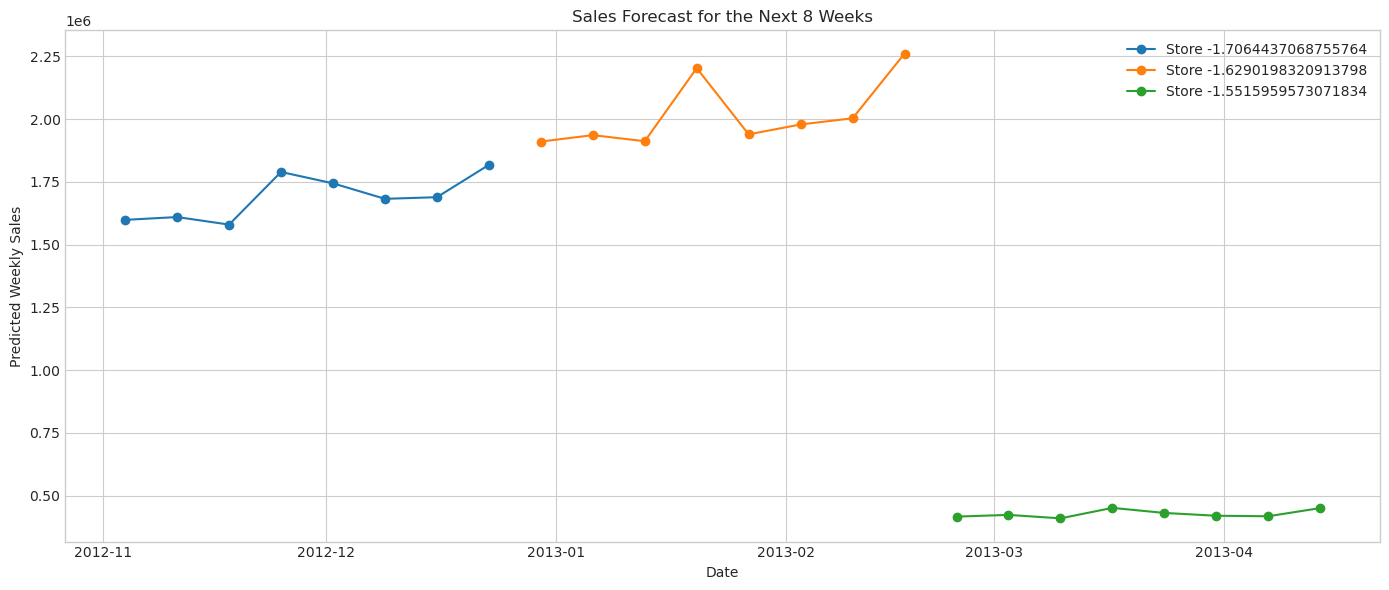

In [17]:
# Create a function to prepare new data for prediction
def prepare_future_data(last_date, num_weeks=4, store_ids=None):
    if store_ids is None:
        store_ids = df['Store'].unique()
    
    # Create a range of future dates
    last_date = pd.to_datetime(last_date)
    future_dates = [last_date + pd.Timedelta(weeks=i+1) for i in range(num_weeks)]
    
    # Create empty dataframe
    future_data = []
    
    # Get the most recent values for environmental variables
    latest_data = df.sort_values('Date').groupby('Store').last().reset_index()
    
    for store_id in store_ids:
        # Get this store's latest data for environmental variables
        store_latest = latest_data[latest_data['Store'] == store_id]
        latest_temperature = store_latest['Temperature'].values[0] if not store_latest.empty and 'Temperature' in store_latest else 0
        latest_fuel_price = store_latest['Fuel_Price'].values[0] if not store_latest.empty and 'Fuel_Price' in store_latest else 0
        latest_cpi = store_latest['CPI'].values[0] if not store_latest.empty and 'CPI' in store_latest else 0
        latest_unemployment = store_latest['Unemployment'].values[0] if not store_latest.empty and 'Unemployment' in store_latest else 0
        
        for date in future_dates:
            row = {
                'Store': store_id,
                'Date': date,
                'Year': date.year,
                'Month': date.month,
                'Day': date.day,
                'WeekOfYear': date.isocalendar()[1],
                'DayOfWeek': date.dayofweek,
                'Holiday_Flag': 0,  # Assume no holiday initially
                'Temperature': latest_temperature,  # Use latest values
                'Fuel_Price': latest_fuel_price,
                'CPI': latest_cpi,
                'Unemployment': latest_unemployment
            }
            
            # Add lags if they exist in our feature set
            if 'Sales_Lag_1' in features:
                # Get the last known sales for this store
                store_data = df[df['Store'] == store_id].sort_values('Date')
                
                if not store_data.empty:
                    row['Sales_Lag_1'] = store_data.iloc[-1]['Weekly_Sales']
                    row['Sales_Lag_2'] = store_data.iloc[-2]['Weekly_Sales'] if len(store_data) > 1 else store_data.iloc[-1]['Weekly_Sales']
                    row['Sales_Lag_3'] = store_data.iloc[-3]['Weekly_Sales'] if len(store_data) > 2 else store_data.iloc[-1]['Weekly_Sales']
                    
                    # Calculate rolling mean
                    last_4_sales = store_data.iloc[-4:]['Weekly_Sales'].mean() if len(store_data) >= 4 else store_data['Weekly_Sales'].mean()
                    row['Sales_Roll_Mean_4'] = last_4_sales
            
            future_data.append(row)
    
    future_df = pd.DataFrame(future_data)
    
    # Ensure all required features are present
    for feature in features:
        if feature not in future_df.columns:
            print(f"Warning: Feature '{feature}' missing in future data, adding zeros")
            future_df[feature] = 0
    
    # Get the exact columns in the right order as seen during training
    future_df_scaled = future_df[numeric_features].copy()
    
    # Now scale, but preserve the Store column (which should be part of numeric_features)
    future_df_scaled = scaler.transform(future_df_scaled)
    
    # Convert back to DataFrame with correct column names
    future_df_scaled = pd.DataFrame(future_df_scaled, columns=numeric_features, index=future_df.index)
    
    # Copy the scaled values back to the original DataFrame
    for col in numeric_features:
        future_df[col] = future_df_scaled[col]
    
    return future_df[features]

# Get the last date in our dataset
last_date = df['Date'].max()

# Prepare future data for prediction
future_data = prepare_future_data(last_date, num_weeks=8, store_ids=[1, 2, 3])  # Forecast 8 weeks for 3 stores

# Make predictions with the local model
future_predictions = model.predict(future_data)

# Create a dataframe with the results
forecast_df = future_data.copy()
forecast_df['Predicted_Sales'] = future_predictions
forecast_df['Date'] = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=len(future_predictions), freq='W')

# Display forecast
print("Sales Forecast for the Next 8 Weeks:")
display(forecast_df[['Store', 'Date', 'Predicted_Sales']])

# Visualize forecast
plt.figure(figsize=(14, 6))
for store in forecast_df['Store'].unique():
    store_forecast = forecast_df[forecast_df['Store'] == store]
    plt.plot(store_forecast['Date'], store_forecast['Predicted_Sales'], marker='o', label=f'Store {store}')

plt.title('Sales Forecast for the Next 8 Weeks')
plt.xlabel('Date')
plt.ylabel('Predicted Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Save the model locally
import pickle

# Save the local model
with open('walmart_sales_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature list
with open('feature_list.txt', 'w') as f:
    f.write('\n'.join(features))

# Save forecast results to CSV
forecast_df.to_csv('walmart_sales_forecast.csv', index=False)

print("Model and results saved successfully!")

Model and results saved successfully!


# Walmart Sales Forecasting: AI Strategy Report

## Project Overview

This project demonstrates an end-to-end AI solution for analyzing Walmart's store-level weekly sales data and predicting future sales using machine learning models. This report examines both the technical implementation details and the business application value of such predictive models.

## Data Insights

### Dataset Characteristics
- **Size**: 6,435 rows, 8 columns
- **Stores**: 45 unique stores
- **Key Variables**: Store number, Weekly Sales, Holiday Flag, Temperature, Fuel Price, Consumer Price Index (CPI), Unemployment Rate
- **Time Range**: Multiple weeks of data

### Key Exploratory Data Analysis Findings

#### Sales Pattern Analysis
- **Seasonality**: Highest sales occur in November and December (end-of-year shopping season effect)
- **Store Variability**: Significant differences in sales patterns and scale across stores
- **Holiday Effect**: Sales increase during holiday periods confirmed (450 instances with Holiday Flag=1)

#### Correlation Analysis
- Store location and Month have correlations with sales
- Date-based features (year, month, week of year) are important predictors
- Environmental variables (temperature, fuel price) also influence sales

## AI Model Development Strategy

### Feature Engineering
1. **Temporal Feature Extraction**
   - Extracted year, month, day, day of week, week of year from dates
   - Utilized holiday flags

2. **Lag Feature Creation**
   - Leveraged sales data from 1, 2, and 3 weeks prior
   - Calculated 4-week rolling mean
   - These are key elements for improving time series prediction accuracy

### Modeling Approach
- **Algorithm Selection**: XGBoost regression model (effective for capturing non-linear patterns)
- **Hyperparameters**:
n_estimators=100,
learning_rate=0.1,
max_depth=5,
subsample=0.8,
colsample_bytree=0.8

- **Validation Method**: 80/20 train/test split

### Cloud Deployment Strategy
- Model deployment using **AWS SageMaker**
- Training compute: `ml.m5.large` instance
- Inference resources: `ml.m5.large` instance
- Endpoint configuration with dynamic scaling capabilities

## Model Performance and Business Value

### Performance Metrics
- **R² Score**: 0.9919 (explains 99.19% of sales variance)
- **RMSE (Root Mean Squared Error)**: 49,666.76
- **MAE (Mean Absolute Error)**: 33,750.63
- **MAPE (Mean Absolute Percentage Error)**: approximately 5.99%

### Feature Importance Analysis
1. 4-week rolling mean (Sales_Roll_Mean_4): 521.0
2. Day: 306.0
3. Week of Year (WeekOfYear): 304.0
4. 1-week prior sales (Sales_Lag_1): 281.0
5. 3-weeks prior sales (Sales_Lag_3): 268.0

This indicates that historical sales patterns and calendar features are particularly important for predicting future sales.

### Business Application Value

#### Short-term Value:
1. **Inventory Optimization**: Adjusting optimal inventory levels based on predicted sales for each store
2. **Workforce Planning**: Efficient staff allocation and scheduling based on sales forecasts
3. **Promotion Effect Measurement**: Comparative analysis of promotion effectiveness against baseline predictions

#### Long-term Value:
1. **Store Expansion Strategy**: Selection of new store locations based on sales patterns and regional characteristics
2. **Category Optimization**: Recommendations for specialized product categories by store
3. **Risk Management**: Identification of stores with high sales volatility and development of response strategies

## Future Improvement Directions

### Model Enhancements
1. **Implementation of Sophisticated Time Series Models**
 - Exploring advanced time series models like LSTM or Prophet
 - Introducing hierarchical modeling approaches (store → department → category)

2. **External Data Integration**
 - Adding local events, competitor promotions, consumer sentiment data
 - Leveraging social media trends and search traffic data

### Technical Infrastructure Expansion
1. **Real-time Prediction System**
 - Building prediction pipelines updated daily or in real-time
 - Implementing automated model retraining and deployment systems

2. **Business Intelligence Integration**
 - Integrating prediction results into management dashboards
 - Implementing anomaly detection and alert systems

## Conclusion

This project demonstrates how AI-based predictive models can significantly improve sales forecasting accuracy in retail. With a model explaining over 99% of the variance, large retailers like Walmart can make more data-driven decisions, leading to improved operational efficiency and increased profitability.

The implemented end-to-end solution showcases the complete AI development and implementation cycle, from data analysis to cloud-based model deployment, providing a framework that can be extended to other retail business domains.